# Wandb extract run info

In [1]:
import wandb
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
api = wandb.Api()
user = "o-swelam"
project = "LLMs"

# Initialize the API
api = wandb.Api()

# Fetch all runs from the project
runs = api.runs(f"{user}/{project}")
config_space_keys = ['learning_rate', 'weight_decay', 'sequence_length', 'batch_size', 'n_embd', 'n_head', 'n_layer']

In [2]:
runs_desired = []

# Loop through each run and filter by the config values
for run in runs:
    config_space = run.config.get("config_space")
    if config_space is None or 'model' not in config_space:
        continue
    if config_space['model'] == 'custom':
        runs_desired.append(run)


In [3]:
runs_total = {}
for run in runs_desired:
    name = '-'.join([f'{k}_{v}' for k, v in run.config.get("config_space").items()])
    if name not in runs_total:
        runs_total[name] = {"runs": [run]}
    else:
        runs_total[name]["runs"].append(run)

# North Star

In [4]:
for name in runs_total:
    runs_list = runs_total[name]["runs"]
    df_list = []
    for run in runs_list:
        df = run.history()
        df["budget"] = run.config.get("budget")
        df["time_taken"] = df["budget"] - df["remaining_time"]
        df_list.append(df)
    df_total = pd.concat(df_list)
    df_total.sort_values(by=["budget", "step"], inplace=True)
    df_total["time_taken"] = df_total["time_taken"].fillna(method='ffill')
    runs_total[name]["train_history"] = df_total.dropna(subset=['avg train loss']).drop_duplicates(subset=['step'], keep='last').reset_index(drop=True)
    runs_total[name]["val_history"] = df_total.dropna(subset=['val_loss']).drop_duplicates(subset=['step'], keep='last').reset_index(drop=True)
    runs_total[name]["config"] = runs_list[0].config.get("config_space")
    runs_total[name]["budget"] = df_total["budget"].max()
    

Text(0.5, 1.0, 'Validation Loss over Time')

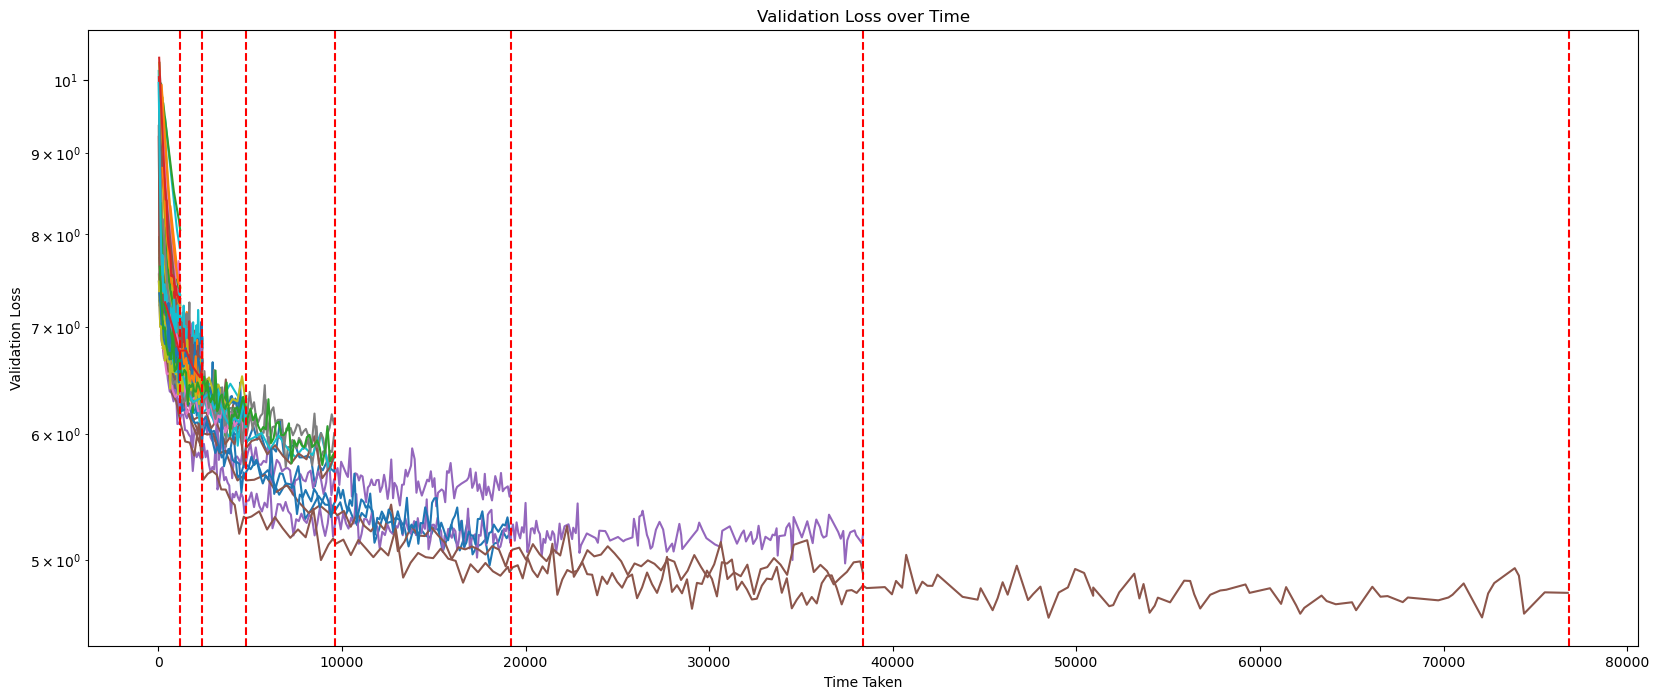

In [31]:
# plot all the val_history values over the x_scale of "time_taken" value and overlaid on the same plot for all of them
import matplotlib.pyplot as plt

budgets = [1200 * 2**(i) for i in range(7)]

# figure size
plt.figure(figsize=(20, 8))
for i, name in enumerate(runs_total):
    plt.plot(runs_total[name]["val_history"]['time_taken'], runs_total[name]["val_history"]['val_loss'], label=f'run({i})')

for budget in budgets:
    plt.axvline(x=budget, color='r', linestyle='--', label=f'budget({budget})')

plt.xlabel('Time Taken')
plt.ylabel('Validation Loss')
plt.yscale('log')
plt.title('Validation Loss over Time')

Text(0.5, 1.0, 'Training Loss over Time')

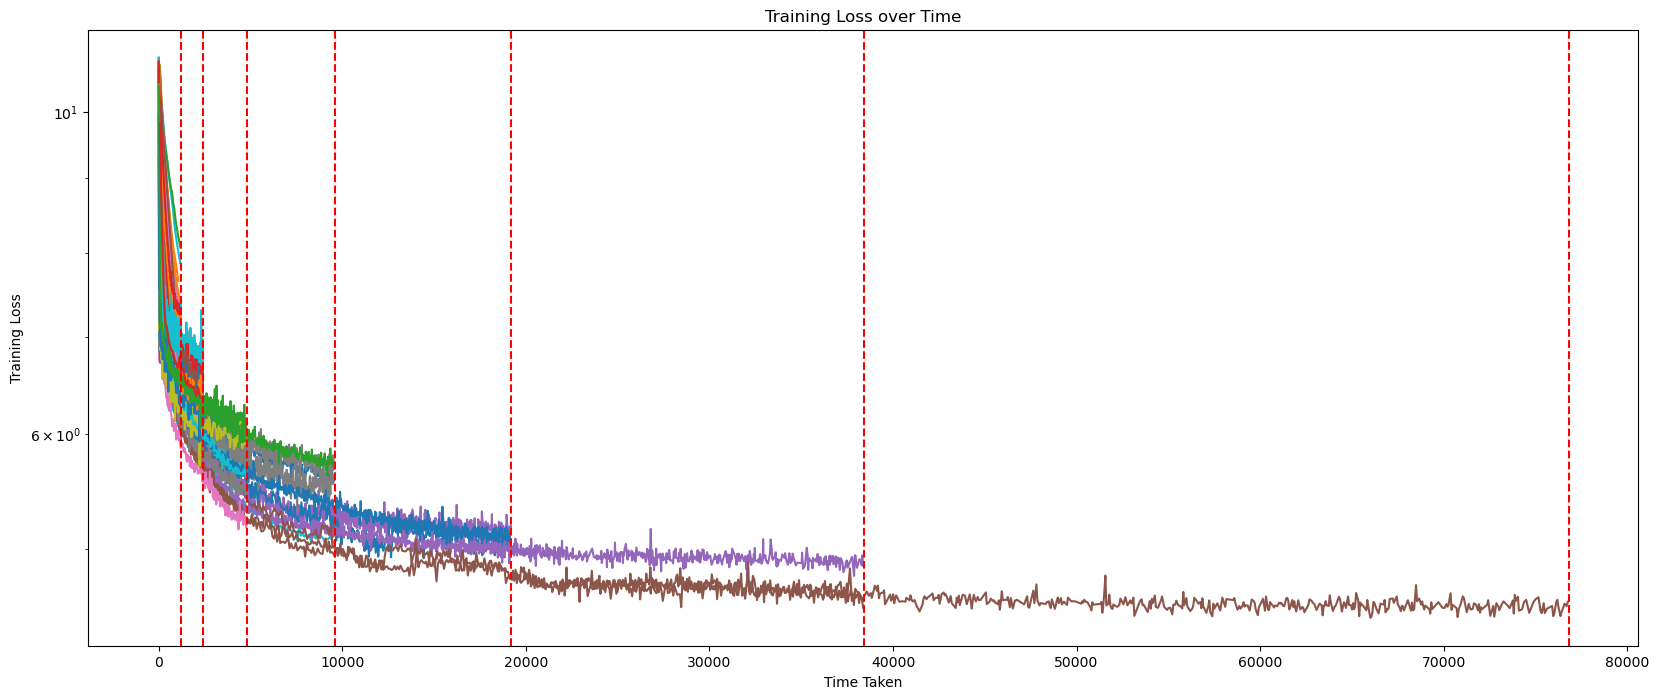

In [30]:
budgets = [1200 * 2**(i) for i in range(7)]

# figure size
plt.figure(figsize=(20, 8))
for i, name in enumerate(runs_total):
    plt.plot(runs_total[name]["train_history"]['time_taken'], runs_total[name]["train_history"]['avg train loss'], label=f'run({i})')

for budget in budgets:
    plt.axvline(x=budget, color='r', linestyle='--', label=f'budget({budget})')

plt.xlabel('Time Taken')
plt.ylabel('Training Loss')
# set y scale to be log scale
plt.yscale('log')
plt.title('Training Loss over Time')

# Configs analysis

In [7]:
budgets = [1200 * 2**(i) for i in range(7)]
df_configs = pd.DataFrame([runs_total[name]["config"] for name in runs_total])
df_configs["budget"] = [runs_total[name]["budget"] for name in runs_total]
df_configs["max_budget"] = df_configs["budget"]
# replicate configs for each budgets in list budgets, smaller than budget in row
for row in df_configs.iterrows():
    for b in budgets:
        if row[1]["budget"] > b:
            row_dict = row[1].copy()
            row_dict["budget"] = b
            df_configs = pd.concat([df_configs, pd.DataFrame([row_dict])], ignore_index=True)
            
configs = list(list(runs_total.values())[0]["config"].keys())
configs.remove("model")

## Visualizations

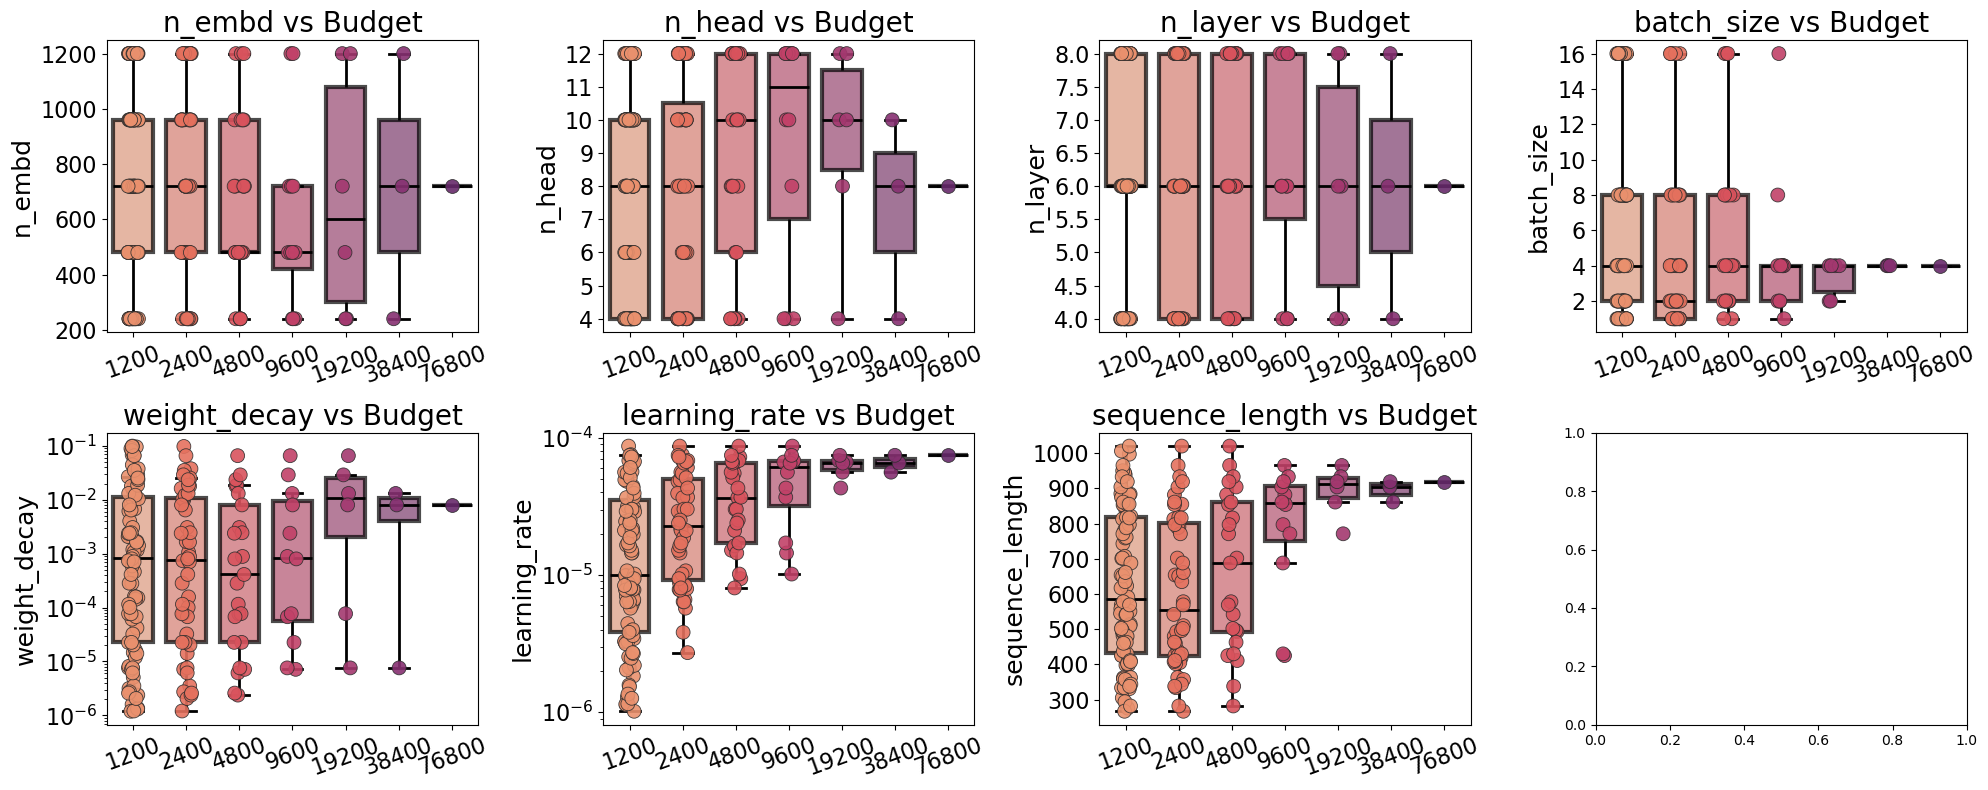

In [29]:
boxprops = {'edgecolor': 'k', 'linewidth': 3, 'alpha': 0.7}
lineprops = {'color': 'k', 'linewidth': 2}
boxplot_kwargs = {'boxprops': boxprops, 'medianprops': lineprops,
                  'whiskerprops': lineprops, 'capprops': lineprops,
                  'width': 0.75, 'palette': 'flare'}

stripplot_kwargs = {'linewidth': 0.6, 'size': 10, 'alpha': 0.9,
                    'palette': 'flare'}

# loop over all configs and plot them in subplots over 3 columms
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i, config in enumerate(configs):
    sns.boxplot(data=df_configs, x='budget', y=config, showfliers=False, ax=axes[i//4, i%4], **boxplot_kwargs)
    sns.stripplot(data=df_configs, x='budget', y=config, jitter=True, ax=axes[i//4, i%4], **stripplot_kwargs)
    
    # Set log scale for specific configurations
    if config in ["learning_rate", "weight_decay"]:
        axes[i//4, i%4].set_yscale('log')
    
    axes[i//4, i%4].set_xlabel("").set_visible(False)
    axes[i//4, i%4].set_ylabel(config, fontsize=18)
    axes[i//4, i%4].set_xticklabels(axes[i//4, i%4].get_xticklabels(), rotation=20, fontsize=16)
    axes[i//4, i%4].set_yticklabels(axes[i//4, i%4].get_yticklabels(), fontsize=16)
    axes[i//4, i%4].set_title(f'{config} vs Budget', fontsize=20)

plt.tight_layout()
plt.show()

## Feature importance

In [13]:
df_prediction = df_configs.drop(columns=["budget"]).drop_duplicates()
df_prediction

,model,n_embd,n_head,n_layer,batch_size,weight_decay,learning_rate,sequence_length,max_budget
0,custom,480,12,4,4,0.000023,0.000014,882,9600
1,custom,240,10,8,1,0.000157,0.000004,813,2400
2,custom,240,12,6,8,0.006142,0.000003,569,1200
3,custom,960,4,6,2,0.009907,0.000007,426,2400
4,custom,480,10,8,2,0.028942,0.000067,771,19200
...,...,...,...,...,...,...,...,...,...
89,custom,960,10,4,8,0.000115,0.000024,502,4800
90,custom,720,10,8,1,0.000002,0.000029,460,2400
91,custom,960,10,6,1,0.000101,0.000019,855,2400
92,custom,720,6,4,2,0.000411,0.000008,816,4800


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import pandas as pd

X = df_prediction[configs]  
y = df_prediction['max_budget']  

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

# Classification report (precision, recall, f1-score)
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({'Feature': configs, 'Importance': rf_classifier.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)


              precision    recall  f1-score   support

           0       0.33      1.00      0.50         3
           1       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2

    accuracy                           0.40        10
   macro avg       0.27      0.27      0.20        10
weighted avg       0.40      0.40      0.30        10

           Feature  Importance
5    learning_rate    0.245158
6  sequence_length    0.206640
3       batch_size    0.145327
4     weight_decay    0.144507
0           n_embd    0.094056
1           n_head    0.093511
2          n_layer    0.070801


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

X = df_prediction[configs]  
y = df_prediction['max_budget']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Feature Importance
feature_importance = pd.DataFrame({'Feature': configs, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)


Mean Squared Error: 178702243.2
           Feature  Importance
5    learning_rate    0.568899
6  sequence_length    0.157699
4     weight_decay    0.085278
0           n_embd    0.069912
3       batch_size    0.053832
1           n_head    0.046069
2          n_layer    0.018311


In [19]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

explainer = shap.TreeExplainer(rf_classifier)  # TreeExplainer for tree-based models like Random Forest
shap_values = explainer.shap_values(X_test)

# Plot summary plot (global feature importance)
shap.summary_plot(shap_values[0], X_test, feature_names=configs)

# Optional: SHAP bar plot for feature importance
shap.summary_plot(shap_values[0], X_test, feature_names=configs, plot_type="bar")

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [21]:
shap_values.shape

(19, 7, 6)

In [2]:
target_lr = 0.00016053955926854287
target_wd = 1.752934617105172e-05
target_sl = 995
matching_runs = []

# Loop through each run and filter by the config values
for run in runs:
    config = run.config  # Run's configuration dictionary
    # print(config)
    config_space = run.config.get("config_space")
    if config_space is None:
        continue
    # Check if 'lr', 'wd', and 'sl' are in the config and match the target values
    if ('learning_rate' in config_space and config_space['learning_rate'] == target_lr and
        'weight_decay' in config_space and config_space['weight_decay'] == target_wd and
        'sequence_length' in config_space and config_space['sequence_length'] == target_sl):
        matching_runs.append(run.history())


In [3]:
import pandas as pd

combined_df = pd.concat(matching_runs).sort_values("step").reset_index(drop=True)
deduplicated_df = combined_df.drop_duplicates(subset='step', keep='last')

# Sort again by step (optional, if you want it sorted after deduplication)
deduplicated_df = deduplicated_df.sort_values("step").reset_index(drop=True)
deduplicated_df

,remaining_time,lr,step,_step,_runtime,val_loss,_timestamp,avg train loss
0,1293.471640,2.293422e-07,0,0,15.561036,NaN,1.726958e+09,10.907496
1,1228.248840,4.609779e-05,200,1,80.783836,NaN,1.726958e+09,9.689851
2,1154.842500,9.196623e-05,400,2,154.235890,NaN,1.726958e+09,7.593662
3,1081.270941,1.378347e-04,600,3,227.803928,NaN,1.726958e+09,6.976192
4,1007.411828,1.605396e-04,800,4,301.620855,NaN,1.726958e+09,6.713572
...,...,...,...,...,...,...,...,...
2046,22520.815168,1.240630e-04,408000,1254,60285.614396,NaN,1.727773e+09,4.388056
2047,22470.708114,1.240302e-04,408200,1255,60335.721387,NaN,1.727773e+09,4.398064
2048,22420.646646,1.239974e-04,408400,1256,60385.782899,NaN,1.727773e+09,4.389914
2049,22370.617292,1.239645e-04,408600,1257,60435.812266,NaN,1.727773e+09,4.397418


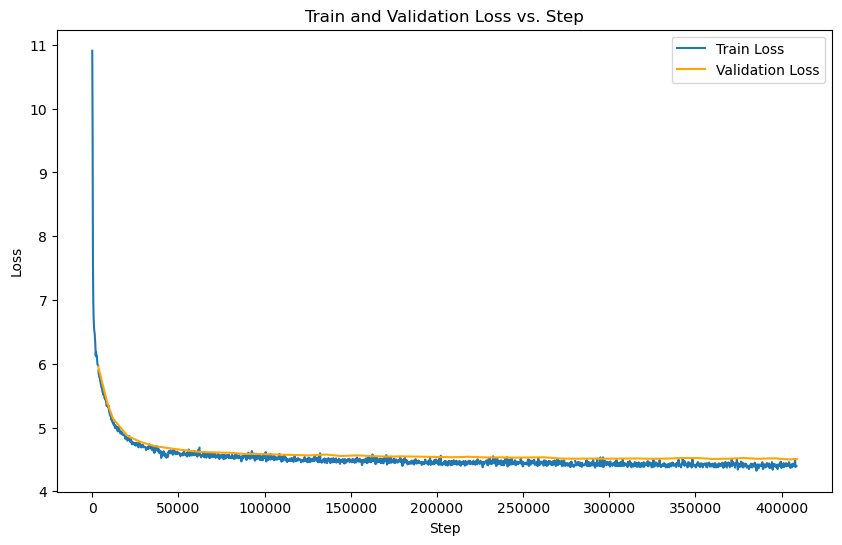

In [6]:
import matplotlib.pyplot as plt

# Plotting train and validation losses on the same plot
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(deduplicated_df['step'], deduplicated_df['avg train loss'], label='Train Loss')

# Plot validation loss, filtering out the zero or negative values
plt.plot(deduplicated_df[deduplicated_df['val_loss'] > 0]['step'], 
         deduplicated_df[deduplicated_df['val_loss'] > 0]['val_loss'], 
         label='Validation Loss', color='orange')

# Add labels and title
plt.title('Train and Validation Loss vs. Step')
plt.xlabel('Step')
plt.ylabel('Loss')

# Show legend
plt.legend()

# Display the plot
plt.show()
